In [2]:
!pip install python-chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148497 sha256=8a7e2a76124d6e3c2a2227b55fa7a475c3b1693b1971492e25aaacff0cf13dd2
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [3]:
!pip install sqlalchemy

In [9]:
!pip install pyarrow  

Looking in indexes: https://gitlab.com/api/v4/groups/81763890/-/packages/pypi/simple, https://gitlab.com/api/v4/groups/13299895/-/packages/pypi/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 1.5 MB/s eta 0:00:0000:0100:010m


In [10]:
!pip install fastparquet

Looking in indexes: https://gitlab.com/api/v4/groups/81763890/-/packages/pypi/simple, https://gitlab.com/api/v4/groups/13299895/-/packages/pypi/simple
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.3/684.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.6 MB/s eta 0:00:00a 0:00:01


In [1]:
import base64
import chess
import chess.pgn
from chess import Board, Move
from enum import Enum
import io
import itertools
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from typing import Iterator, List

In [2]:
sys.path.append("../../csce_5218_and_csce_5320/chess-ml/chess-ml-dao")

In [3]:
os.environ["POSTGRES_TOTAL_GAMES"]=str(25162)

In [4]:
from chess_ml_dao.dao.postgres import PGNDAO
from chess_ml_dao.algo import ChessMoveModel
from chess_ml_dao.model.transformation import PlayerTurn
from chess_ml_dao.model.general import ChessPredictionMove
from chess_ml_dao.util.transformation import get_board_array, \
                                             get_players_turn_array, \
                                             generate_all_possible_white_promotion_moves, \
                                             generate_all_possible_black_promotion_moves, \
                                             generate_black_castling, \
                                             generate_white_castling, \
                                             POSSIBLE_MOVES

In [5]:
# Read all Parquet files in the directory
parquet_dir = "/tmp/parquet"
all_moves = pd.concat([pd.read_parquet(os.path.join(parquet_dir, file)) for file in os.listdir(parquet_dir) if file.endswith(".parquet")])
all_moves

,move_id,game_id,move_number,move,board_base64,move_mask_base64,move_label
0,816580,10125,32,d8c8,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,2007
1,816581,10125,33,d5e7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,1830
2,816582,10125,34,e8e7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,2534
3,816583,10125,35,g5e7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,3366
4,816584,10125,36,c8d7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,1502
...,...,...,...,...,...,...,...
204139,408287,5038,101,b5b4,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,779
204140,408288,5038,102,d4c6,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,1749
204141,408289,5038,103,b4c5,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,724
204142,408290,5038,104,c6a5,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,1348


In [6]:
def decode_base64_column(column):
    return column.apply(lambda x: base64.b64decode(x) if pd.notnull(x) else x)

In [7]:
all_moves["board"] = decode_base64_column(all_moves["board_base64"])

In [8]:
all_moves.drop(columns=["board_base64"], inplace=True)

In [ ]:
all_moves["move_mask"] = decode_base64_column(all_moves["move_mask_base64"])

In [ ]:
all_moves.drop(columns=["move_mask_base64"], inplace=True)

In [25]:
all_moves.head()

,move_id,game_id,move_number,move,board_base64,move_mask_base64,move_label,board
0,816580,10125,32,d8c8,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,2007,"b""\x93NUMPY\x01\x00v\x00{'descr': '<i8', 'fort..."
1,816581,10125,33,d5e7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,1830,"b""\x93NUMPY\x01\x00v\x00{'descr': '<i8', 'fort..."
2,816582,10125,34,e8e7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,2534,"b""\x93NUMPY\x01\x00v\x00{'descr': '<i8', 'fort..."
3,816583,10125,35,g5e7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,3366,"b""\x93NUMPY\x01\x00v\x00{'descr': '<i8', 'fort..."
4,816584,10125,36,c8d7,k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...,k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...,1502,"b""\x93NUMPY\x01\x00v\x00{'descr': '<i8', 'fort..."


In [26]:
all_moves["move_mask"]

KeyError: 'move_mask'

In [13]:
all_games = PGNDAO.get_chess_games()
all_games

,game_id,lichess_game_id,site,date,round,white,black,white_elo,black_elo,winner,pgn,eco
0,1,RTZfgncTSbexaiNnmXgUKw,SocialChess,2020-12-31,-,9,10.0,1311,1282,9.0,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C40
1,2,loVB87mxTwG8tm461lgHZg,SocialChess,2021-01-05,-,10,9.0,1284,1224,10.0,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
2,3,QYHv3_CPQ76F4cxek8eF1w,SocialChess,2021-01-10,-,9,10.0,1306,1282,9.0,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C46
3,4,mu2AtNfBTRu25u5T9TkdwA,SocialChess,2021-01-17,-,10,9.0,1280,1362,9.0,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
4,5,TdRVJboKRpeWgojTzXvJ9A,SocialChess,2021-01-25,-,9,10.0,1300,1284,10.0,"[Event ""5d""]\n[Site ""SocialChess""]\n[Date ""202...",C41
...,...,...,...,...,...,...,...,...,...,...,...,...
25157,25158,75723640-02c1-414b-b299-786deaf51d4e,?,2021-07-01,-,6982,6924.0,2596,2507,6924.0,"[Event ""Rated Blitz tournament https://lichess...",B27
25158,25159,0f92fcbd-9ed1-47ef-913e-7f077497e50c,?,2021-07-01,-,6965,6983.0,2723,2497,0.0,"[Event ""Rated Blitz tournament https://lichess...",E62
25159,25160,81e0c3f8-830a-4daf-a6f6-eab7cb650b20,?,2021-07-01,-,6921,8300.0,2606,2392,6921.0,"[Event ""Rated Blitz tournament https://lichess...",A57
25160,25161,39a49c1a-2def-4283-99da-f442e2114ef8,?,2021-07-01,-,7181,7029.0,2413,2373,7029.0,"[Event ""Rated Blitz tournament https://lichess...",A46


In [ ]:
all_moves = PGNDAO.get_chess_moves()
all_moves

In [8]:
all_games[all_games["game_id"] == 3]["pgn"].iloc[0]

'[Event "3d"]\n[Site "SocialChess"]\n[Date "2021.01.10"]\n[Round "-"]\n[White "ministeroffinance"]\n[Black "Mike 0787"]\n[Result "1-0"]\n[WhiteElo "1306"]\n[BlackElo "1282"]\n[GameId "QYHv3_CPQ76F4cxek8eF1w"]\n[ECO "C46"]\n\n1. e4 e5 2. Nf3 Nc6 3. Nc3 Bb4 4. Nd5 Bc5 5. a3 Nd4 6. b4 Nb3 7. cxb3 Bxf2+ 8. Kxf2 d6 9. a4 Bg4 10. h3 Bh5 11. g4 Nf6 12. gxh5 Nxe4+ 13. Ke3 f5 14. Rg1 c6 15. Nc3 Qb6+ 16. Ke2 Qf2+ 17. Kd3 Qxg1 18. Nxg1 Nf2+ 19. Ke2 Nxd1 20. Kxd1 O-O-O 21. d3 g6 22. h6 Rhg8 23. Nf3 e4 24. dxe4 Rge8 25. exf5 gxf5 26. Ng5 Re7 27. Bd3 Rf8 28. Bf4 Kc7 29. Ra2 c5 30. Re2 Rfe8 31. bxc5 Re4 32. Bxe4 Rxe4 33. Ngxe4 fxe4 34. Rxe4 Kc6 35. cxd6 b5 36. axb5+ Kd7 37. Nd5 a5 38. Re7+ Kd8 39. d7 a4 40. Bc7# 1-0'

In [9]:
pgn_game_3 = io.StringIO(all_games[all_games["game_id"] == 3]["pgn"].iloc[0])
print(pgn_game_3)

In [10]:
game_3 = chess.pgn.read_game(pgn_game_3)
game_3

<Game at 0x155cb76a0 ('ministeroffinance' vs. 'Mike 0787', '2021.01.10' at 'SocialChess')>

In [11]:
moves = iter(game_3.mainline_moves())
moves

<generator object Mainline.__iter__ at 0x1569e6430>

In [12]:
game_3.mainline_moves()

<Mainline at 0x155cc0880 (1. e4 e5 2. Nf3 Nc6 3. Nc3 Bb4 4. Nd5 Bc5 5. a3 Nd4 6. b4 Nb3 7. cxb3 Bxf2+ 8. Kxf2 d6 9. a4 Bg4 10. h3 Bh5 11. g4 Nf6 12. gxh5 Nxe4+ 13. Ke3 f5 14. Rg1 c6 15. Nc3 Qb6+ 16. Ke2 Qf2+ 17. Kd3 Qxg1 18. Nxg1 Nf2+ 19. Ke2 Nxd1 20. Kxd1 O-O-O 21. d3 g6 22. h6 Rhg8 23. Nf3 e4 24. dxe4 Rge8 25. exf5 gxf5 26. Ng5 Re7 27. Bd3 Rf8 28. Bf4 Kc7 29. Ra2 c5 30. Re2 Rfe8 31. bxc5 Re4 32. Bxe4 Rxe4 33. Ngxe4 fxe4 34. Rxe4 Kc6 35. cxd6 b5 36. axb5+ Kd7 37. Nd5 a5 38. Re7+ Kd8 39. d7 a4 40. Bc7#)>

In [13]:
all_games[all_games["game_id"] == 4]

,game_id,lichess_game_id,site,date,round,white,black,white_elo,black_elo,winner,pgn,eco
3,4,mu2AtNfBTRu25u5T9TkdwA,SocialChess,2021-01-17,-,10,9,1280,1362,9,"[Event ""3d""]\n[Site ""SocialChess""]\n[Date ""202...",C41


In [14]:
g_3_str = all_games[all_games["game_id"] == 3]["pgn"].iloc[0]
g_4_str = all_games[all_games["game_id"] == 4]["pgn"].iloc[0]

In [15]:
g_3_str

'[Event "3d"]\n[Site "SocialChess"]\n[Date "2021.01.10"]\n[Round "-"]\n[White "ministeroffinance"]\n[Black "Mike 0787"]\n[Result "1-0"]\n[WhiteElo "1306"]\n[BlackElo "1282"]\n[GameId "QYHv3_CPQ76F4cxek8eF1w"]\n[ECO "C46"]\n\n1. e4 e5 2. Nf3 Nc6 3. Nc3 Bb4 4. Nd5 Bc5 5. a3 Nd4 6. b4 Nb3 7. cxb3 Bxf2+ 8. Kxf2 d6 9. a4 Bg4 10. h3 Bh5 11. g4 Nf6 12. gxh5 Nxe4+ 13. Ke3 f5 14. Rg1 c6 15. Nc3 Qb6+ 16. Ke2 Qf2+ 17. Kd3 Qxg1 18. Nxg1 Nf2+ 19. Ke2 Nxd1 20. Kxd1 O-O-O 21. d3 g6 22. h6 Rhg8 23. Nf3 e4 24. dxe4 Rge8 25. exf5 gxf5 26. Ng5 Re7 27. Bd3 Rf8 28. Bf4 Kc7 29. Ra2 c5 30. Re2 Rfe8 31. bxc5 Re4 32. Bxe4 Rxe4 33. Ngxe4 fxe4 34. Rxe4 Kc6 35. cxd6 b5 36. axb5+ Kd7 37. Nd5 a5 38. Re7+ Kd8 39. d7 a4 40. Bc7# 1-0'

In [19]:
g_4_str

'[Event "3d"]\n[Site "SocialChess"]\n[Date "2021.01.17"]\n[Round "-"]\n[White "Mike 0787"]\n[Black "ministeroffinance"]\n[Result "0-1"]\n[WhiteElo "1280"]\n[BlackElo "1362"]\n[GameId "mu2AtNfBTRu25u5T9TkdwA"]\n[ECO "C41"]\n\n1. e4 e5 2. Nf3 d6 3. d4 Nc6 4. Bc4 a6 5. dxe5 dxe5 6. Bxf7+ Kxf7 7. Nxe5+ Ke7 8. Bg5+ Nf6 9. Qh5 g6 10. Bxf6+ Kxf6 11. Nxc6 bxc6 12. Qf3+ Ke7 13. O-O Rb8 14. e5 Ke8 15. Re1 Bg7 16. e6 Rf8 17. Qxc6+ Ke7 18. Na3 Qd6 19. Qa4 Rxb2 20. Qh4+ Bf6 21. Qxh7+ Kd8 22. Rad1 Bd4 23. e7+ Ke8 24. Rxd4 Qxd4 25. exf8=Q+ Kxf8 26. Qe7+ Kg8 27. Qe8+ Kh7 28. Re7+ Kh6 29. Qh8+ Qxh8 30. Re3 Rxa2 31. Nb1 Rxc2 32. f4 Rc1+ 33. Kf2 Kg7 34. Re7+ Kf6 35. Re1 Rc2+ 36. Kg1 Bb7 37. f5 Rxg2+ 38. Kf1 Qg8 39. Nd2 Rxd2 40. Re2 Rd1+ 41. Kf2 Qc4 42. Re6+ Kxf5 43. Rxg6 Kxg6 44. h4 Qxh4+ 45. Ke2 Qe1# 0-1'

In [20]:
board = game_3.board()

In [21]:
moves

<generator object Mainline.__iter__ at 0x1569e6430>

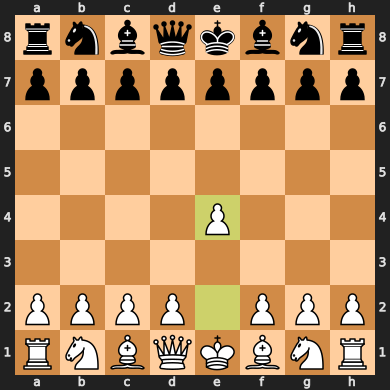

In [22]:
ChessMoveModel.make_move(board, moves)
board

In [18]:
all_games.to_csv("/tmp/all_games.csv")

In [23]:
pgn_game_1 = io.StringIO(all_games["pgn"][0])
pgn_game_1

In [24]:
game_1 = chess.pgn.read_game(pgn_game_1)
game_1

<Game at 0x155c3b340 ('ministeroffinance' vs. 'Mike 0787', '2020.12.31' at 'SocialChess')>

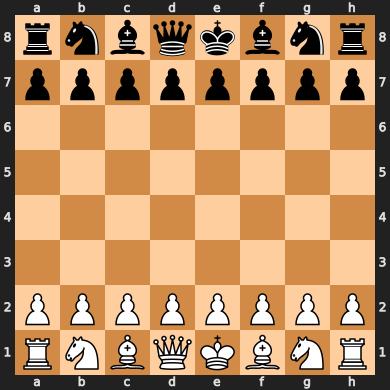

In [25]:
board = game_1.board()
board

In [26]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [27]:
moves = iter(game_1.mainline_moves())
moves

<generator object Mainline.__iter__ at 0x157b826d0>

In [28]:
board_array = get_board_array(board)
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

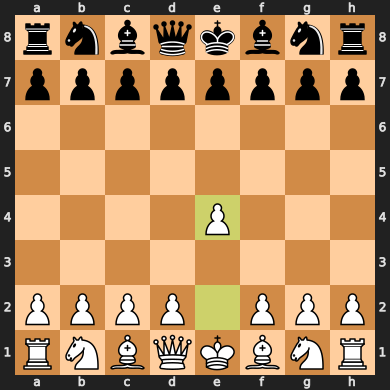

In [29]:
ChessMoveModel.make_move(board, moves)
board

In [30]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


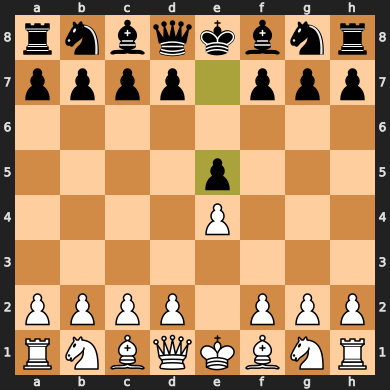

In [31]:
ChessMoveModel.make_move(board, moves)
board

In [32]:
print(board)

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


In [33]:
board_array = get_board_array(board)
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

In [34]:
white_players_turn = get_players_turn_array(PlayerTurn.WHITE)
white_players_turn

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

In [35]:
black_players_turn = get_players_turn_array(PlayerTurn.BLACK)
black_players_turn

array([[-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1, -1]])

In [36]:
input_tensor = np.stack([board_array, black_players_turn], axis=0)
input_tensor

array([[[ 4,  2,  3,  5,  6,  3,  2,  4],
        [ 1,  1,  1,  1,  0,  1,  1,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  1,  0,  0,  0],
        [ 0,  0,  0,  0, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [-1, -1, -1, -1,  0, -1, -1, -1],
        [-4, -2, -3, -5, -6, -3, -2, -4]],

       [[-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1]]])

In [37]:
board_array

array([[ 4,  2,  3,  5,  6,  3,  2,  4],
       [ 1,  1,  1,  1,  0,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [-1, -1, -1, -1,  0, -1, -1, -1],
       [-4, -2, -3, -5, -6, -3, -2, -4]])

In [38]:
white_promotion_moves = generate_all_possible_white_promotion_moves()

In [39]:
black_promotion_moves = generate_all_possible_black_promotion_moves()

In [40]:
black_castling = generate_black_castling()
black_castling

['e8g8', 'e8c8']

In [41]:
white_castling = generate_white_castling()
white_castling

['e1g1', 'e1c1']

In [42]:
board.legal_moves

<LegalMoveGenerator at 0x156914cd0 (Nh3, Nf3, Ne2, Ba6, Bb5, Bc4, Bd3, Be2, Ke2, Qh5, Qg4, Qf3, Qe2, Nc3, Na3, h3, g3, f3, d3, c3, b3, a3, h4, g4, f4, d4, c4, b4, a4)>

In [43]:
legal_moves = list(board.legal_moves)

In [44]:
legal_uci_moves = [move.uci() for move in legal_moves]

In [45]:
 generate_all_possible_white_promotion_moves()

['a7a8q',
 'a7b8q',
 'a7c8q',
 'a7d8q',
 'a7e8q',
 'a7f8q',
 'a7g8q',
 'a7h8q',
 'a7a8r',
 'a7b8r',
 'a7c8r',
 'a7d8r',
 'a7e8r',
 'a7f8r',
 'a7g8r',
 'a7h8r',
 'a7a8b',
 'a7b8b',
 'a7c8b',
 'a7d8b',
 'a7e8b',
 'a7f8b',
 'a7g8b',
 'a7h8b',
 'a7a8n',
 'a7b8n',
 'a7c8n',
 'a7d8n',
 'a7e8n',
 'a7f8n',
 'a7g8n',
 'a7h8n',
 'b7b8q',
 'b7a8q',
 'b7c8q',
 'b7d8q',
 'b7e8q',
 'b7f8q',
 'b7g8q',
 'b7h8q',
 'b7b8r',
 'b7a8r',
 'b7c8r',
 'b7d8r',
 'b7e8r',
 'b7f8r',
 'b7g8r',
 'b7h8r',
 'b7b8b',
 'b7a8b',
 'b7c8b',
 'b7d8b',
 'b7e8b',
 'b7f8b',
 'b7g8b',
 'b7h8b',
 'b7b8n',
 'b7a8n',
 'b7c8n',
 'b7d8n',
 'b7e8n',
 'b7f8n',
 'b7g8n',
 'b7h8n',
 'c7c8q',
 'c7a8q',
 'c7b8q',
 'c7d8q',
 'c7e8q',
 'c7f8q',
 'c7g8q',
 'c7h8q',
 'c7c8r',
 'c7a8r',
 'c7b8r',
 'c7d8r',
 'c7e8r',
 'c7f8r',
 'c7g8r',
 'c7h8r',
 'c7c8b',
 'c7a8b',
 'c7b8b',
 'c7d8b',
 'c7e8b',
 'c7f8b',
 'c7g8b',
 'c7h8b',
 'c7c8n',
 'c7a8n',
 'c7b8n',
 'c7d8n',
 'c7e8n',
 'c7f8n',
 'c7g8n',
 'c7h8n',
 'd7d8q',
 'd7a8q',
 'd7b8q',
 'd7c8q',


In [46]:
move = ChessMoveModel.make_move(board, moves)
move

Move.from_uci('g1f3')

In [47]:
move = ChessMoveModel.make_move(board, moves)
move

Move.from_uci('d7d5')

moves

In [48]:
moves

<generator object Mainline.__iter__ at 0x157b826d0>

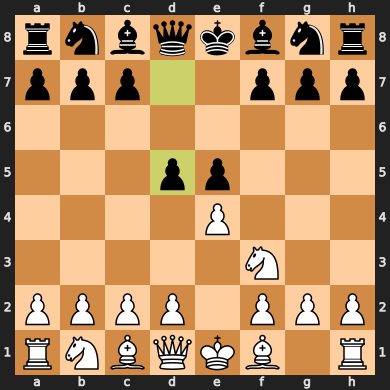

In [49]:
board

In [50]:
len(POSSIBLE_MOVES)

4612

In [51]:
type(POSSIBLE_MOVES[0])

str

In [6]:
class ChessDataset(Dataset):
    def __init__(self, moves: DataFrame):
        self.moves = moves

    def __len__(self):
        return len(self.moves)

    def __getitem__(self, idx: int):
        board = self._get_board(idx)
        move_mask = self._get_move_mask(idx)
        move_label = self.moves.iloc[idx]['move_label'] 
        
        board_tensor = torch.tensor(board, dtype=torch.float32)
        move_mask_tensor = torch.tensor(move_mask, dtype=torch.float32)
        move_label_tensor = torch.tensor(move_label, dtype=torch.long)

        return board_tensor, move_mask_tensor, move_label_tensor

    def _get_board(self, idx: int) -> np.ndarray:
        board = self.moves.iloc[idx]['board_base64']
        
        return ChessPredictionMove.deserialize_array(board)
        
    def _get_move_mask(self, idx: int) -> np.ndarray:
        move_mask = self.moves.iloc[idx]['move_mask_base64']
        
        return ChessPredictionMove.deserialize_array(move_mask)
        

In [7]:
def padding_fn(batch):
    boards, move_masks, move_labels = zip(*batch)

    boards = pad_sequence(boards, batch_first=True, padding_value=0)
    move_masks = pad_sequence(move_masks, batch_first=True, padding_value=0)
    move_labels = pad_sequence(move_labels, batch_first=True, padding_value=-1)


    return boards, move_masks, move_labels

In [8]:
def padding_fn(batch):
    boards, move_masks, move_labels = zip(*batch)

    # Pad boards and move_masks as usual
    boards = pad_sequence(boards, batch_first=True, padding_value=0)
    move_masks = pad_sequence(move_masks, batch_first=True, padding_value=0)

    # Ensure all move_labels are 1-dimensional by unsqueezing 0-d tensors
    move_labels = [label if label.dim() > 0 else label.unsqueeze(0) for label in move_labels]

    # Filter out empty move labels (if any)
    non_empty_labels = [label for label in move_labels if label.size(0) > 0]

    # Pad move_labels only if there are non-empty labels
    if non_empty_labels:
        move_labels = pad_sequence(non_empty_labels, batch_first=True, padding_value=-1)
    else:
        move_labels = torch.empty(0)  # Return an empty tensor if all labels were empty

    return boards, move_masks, move_labels

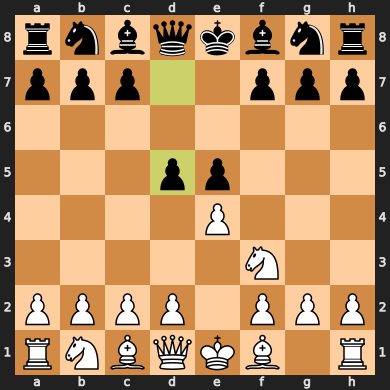

In [54]:
board

In [201]:
with open("possible_moves.txt", "w") as file:
    for move in POSSIBLE_MOVES:
        file.write(f"{move}\n")  # Write each item on a new line

In [9]:
chess_dataset = ChessDataset(all_moves)
chess_dataset

In [10]:
chess_dataset.moves.iloc[0]

move_id                                                        816580
game_id                                                         10125
move_number                                                        32
move                                                             d8c8
board_base64        k05VTVBZAQB2AHsnZGVzY3InOiAnPGk4JywgJ2ZvcnRyYW...
move_mask_base64    k05VTVBZAQB2AHsnZGVzY3InOiAnPGY4JywgJ2ZvcnRyYW...
move_label                                                       2007
Name: 0, dtype: object

In [12]:
total_number_of_moves = len(all_moves)
total_number_of_moves

2041447

In [13]:
train_dataset_size = int(0.7 * total_number_of_moves)
validation_dataset_size = int(0.15 * total_number_of_moves)
test_dataset_size = total_number_of_moves - train_dataset_size - validation_dataset_size

In [14]:
train_dataset, validation_dataset, test_dataset = random_split(chess_dataset, [train_dataset_size, validation_dataset_size, test_dataset_size])

In [15]:
BATCH_SIZE = 32

In [16]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=padding_fn)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=padding_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=padding_fn)

In [17]:
len(train_loader)

44657

In [18]:
chess_dataset.__getitem__(0)

KeyError: 'board'

In [76]:
class ChessMoveModel(nn.Module):
    def __init__(self, number_of_possible_moves):
        super(ChessMoveModel, self).__init__()

        # Convulutional Layers
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=2, kernel_size=3, stride=1, padding=1)

        # Fully Connected Layers
        self.fc1 = nn.Linear(8 * 8 * 2, 512)
        self.fc2 = nn.Linear(512, number_of_possible_moves)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1) # Flatten from (8, 8, 2) to (128,)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)           #  Output logits for the predicted move

        return x

In [77]:
num_possible_moves = len(POSSIBLE_MOVES)
model = ChessMoveModel(num_possible_moves)
model

ChessMoveModel(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=128, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4612, bias=True)
)

In [78]:
def calculate_accuracy(outputs, labels):
    predicated = outputs.argmax(-1)
    correct = (predicated == labels).sum().item()
    total = labels.size(0)

    return correct / total

In [97]:
EPOCHS = 100
LEARNING_RATE = 0.0001

# Assuming calculate_accuracy is defined elsewhere

def train_model(model, train_loader, val_loader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=-1)

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        total_accuracy = []

        # Training loop
        for boards, move_masks, move_labels in train_loader:
            batch_size, channels, board_height, board_width = boards.size()
            num_possible_moves = move_masks.size(-1)

            # Reshape for model input
            boards = boards.view(batch_size, channels, board_height, board_width)
            move_masks = move_masks.view(batch_size, num_possible_moves)
            move_labels = move_labels.view(batch_size)

            # Forward pass
            outputs = model(boards)
            masked_output_moves = outputs * move_masks
            loss = criterion(masked_output_moves, move_labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track accuracy for each batch
            accuracy = calculate_accuracy(outputs, move_labels)
            total_accuracy.append(accuracy)
            epoch_loss += loss.item()

        # Calculate average accuracy and loss for the epoch
        average_train_accuracy = np.mean(total_accuracy)
        average_train_loss = epoch_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0
        total_validation_accuracy = []

        with torch.no_grad():
            for val_boards, val_move_masks, val_move_labels in val_loader:
                batch_size, channels, board_height, board_width = boards.size()
                val_boards = boards.view(batch_size, channels, board_height, board_width)
                val_move_masks = move_masks.view(batch_size, num_possible_moves)
                val_move_labels = move_labels.view(batch_size)

                outputs = model(val_boards)
                masked_val_outputs = outputs * val_move_masks
                val_batch_loss = criterion(masked_val_outputs, val_move_labels)
                val_loss += val_batch_loss.item()

                # Track validation accuracy
                accuracy_val = calculate_accuracy(outputs, val_move_labels)
                total_validation_accuracy.append(accuracy_val)

        # Calculate average validation loss and accuracy
        average_val_accuracy = np.mean(total_validation_accuracy)
        average_val_loss = val_loss / len(val_loader)

        # Print training and validation metrics for the epoch
        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {average_train_loss:.4f}, Train Accuracy: {average_train_accuracy:.4f}, "
              f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")



In [98]:
train_model(model, train_loader, val_loader, EPOCHS, LEARNING_RATE)

Epoch [1/5], Train Loss: 6.0580, Train Accuracy: 0.0144, Validation Loss: 4.2287, Validation Accuracy: 0.1111
Epoch [2/5], Train Loss: 4.8901, Train Accuracy: 0.0146, Validation Loss: 3.5364, Validation Accuracy: 0.0000
Epoch [3/5], Train Loss: 4.1341, Train Accuracy: 0.0156, Validation Loss: 3.0500, Validation Accuracy: 0.0000
Epoch [4/5], Train Loss: 3.6755, Train Accuracy: 0.0083, Validation Loss: 2.3847, Validation Accuracy: 0.0000
Epoch [5/5], Train Loss: 3.3890, Train Accuracy: 0.0063, Validation Loss: 4.0450, Validation Accuracy: 0.0000


In [78]:
all_games[PGN_COLUMN].tolist()[152]

'[Event "5d"]\n[Site "SocialChess"]\n[Date "2022.07.04"]\n[Round "-"]\n[White "ministeroffinance"]\n[Black "Mike 0787"]\n[Result "1-0"]\n[WhiteElo "1212"]\n[BlackElo "1267"]\n[GameId "51Xh5VoxQx6auxXTNplTRQ"]\n[ECO "D06"]\n\n1. d4 d5 2. c4 Nf6 3. c5 e5 4. f3 e4 5. Nc3 exf3 6. gxf3 Na6 7. a3 b6 8. b4 Nd7 9. Nxd5 Qh4+ 10. Kd2 Qxd4+ 11. Ke1 Qxa1 12. Bf4 Qxa3 13. Kf2 bxc5 14. b5 c6 15. bxc6 Nb6 16. e4 Na4 17. Bxa6 Nb2 18. Nc7+ Ke7 19. Qd5 Nd3+ 20. Kg3 Rb8 21. Ne2 Bxa6 22. Rd1 Rd8 23. Bg5+ f6 24. Qe6# 1-0'

In [248]:
drive.mount('/content/drive')

Mounted at /content/drive


In [250]:
torch.save(model.state_dict(), '/content/drive/MyDrive/UNT/CSCE 5218/Semester Project/models/cnn.10.27.12.13.pytorch')